In [3]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=5)

%load_ext autoreload
%autoreload 2

In [4]:
ok.__version__

'1.5.0'

### Plot WealthIndexDCF with CashFlow (Function)

In [2]:
def plot_wealth_with_cf(pf: ok.Portfolio, discounting: str = "pv"):
    import matplotlib.figure as mfigure
    import matplotlib.axes as maxes
    import matplotlib.dates as mdates
    import pandas as pd
    import numpy as np

    # fig, ax = plt.subplots()
    pf_symbol = pf.symbol
    wi = pf.dcf.wealth_index(discounting=discounting, include_negative_values=False)
    cf = pf.dcf.cash_flow_ts(discounting=discounting, remove_if_wealth_index_negative=True)
    # 1. Создаем объект Figure
    fig = mfigure.Figure(figsize=(10, 6))

    # 2. Добавляем основную ось для столбчатой диаграммы
    ax1 = fig.add_subplot()

    # 3. Строим столбчатую диаграмму
    bars = ax1.bar(
        x=np.arange(len(cf)),
        height=cf.values,
        width=1.6,
        color='skyblue',
        alpha=0.7,
        label='Денежные потоки'
    )

    # 4. Добавляем вторичную ось (для линейного графика)
    ax2 = ax1.twinx()

    # 5. Строим линейный график
    line = ax2.plot(
        np.arange(len(wi)),
        wi[pf_symbol].values,
        color='red',
        # marker='o',
        linestyle='-',
        linewidth=2,
        label='Баланс портфеля'
    )[0]  # plot возвращает список линий

    # 6. Настраиваем оформление
    # Ось Y
    max_cf = cf.min()
    ax1.set_ylim(0, max_cf * 2)
    # Ось X: метки дат
    ax1.set_xticks(np.arange(len(cf)))
    ax1.set_xticklabels([d.strftime('%Y-%m') for d in cf.index], rotation=45)

    # Подписи осей
    ax1.set_xlabel('Даты')
    ax1.set_ylabel('Изъятия и пополнения', color='skyblue')
    ax2.set_ylabel('Баланс портфеля', color='red')

    # настройка максимального количества подписей оси Х
    from matplotlib.ticker import MaxNLocator
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))

    # Цвета меток осей
    ax1.tick_params(axis='y', colors='skyblue')
    ax2.tick_params(axis='y', colors='red')

    # Легенда (объединяем элементы с обеих осей)
    from matplotlib.legend import Legend
    handles = [bars, line]
    labels = [h.get_label() for h in handles]
    legend = Legend(fig, handles, labels, loc='upper left')
    fig.artists.append(legend)

    # Заголовок
    fig.suptitle('Баланс инвестиционного портфеля и денежные потоки', fontsize=14)

    # Сетка
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 7. Сохранение или отображение
    # from matplotlib.backends.backend_agg import FigureCanvasAgg
    # canvas = FigureCanvasAgg(fig)
    # canvas.print_figure('combined_chart.png')  # Сохраняем в файл

    # Для отображения в Jupyter:
    from IPython.display import display
    display(fig)

NameError: name 'ok' is not defined

## DCF

In [5]:
assets = ['RGBITR.INDX', 'RUCBTRNS.INDX', 'MCFTR.INDX', 'GC.COMM']
assets1 = ["MCFTR.INDX", "GC.COMM"]
assets2 = ["SPY.US", "AGG.US", "GC.COMM"]
assets3 = ['MCFTR.INDX']

In [6]:
weights = [0.20, 0.20, 0.40, 0.20]

pf = ok.Portfolio(
    assets,
    ccy="RUB",
    weights=weights,
    # first_date='2013-01',
    # last_date='2024-12',
    inflation=True,
    # symbol="retirement_pf.PF",
    rebalancing_strategy=ok.Rebalance(period="year"),
)
print(pf)

symbol                                                       portfolio_1908.PF
assets                       [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                                   [0.2, 0.2, 0.4, 0.2]
rebalancing_period                                                        year
rebalancing_abs_deviation                                                 None
rebalancing_rel_deviation                                                 None
currency                                                                   RUB
inflation                                                             RUB.INFL
first_date                                                             2003-01
last_date                                                              2025-07
period_length                                               22 years, 7 months
dtype: object


In [6]:
pf.dcf.discount_rate = 0.09

In [7]:
pf.symbol = "Portfolio.PF"

In [202]:
pf.describe()

,property,period,Portfolio.PF,inflation
0,compound return,YTD,0.08415,0.04595
1,CAGR,1 years,0.17065,0.09034
2,CAGR,5 years,0.08948,0.08744
3,CAGR,10 years,0.12566,0.06495
4,CAGR,"22 years, 7 months",0.14493,0.08447
5,Annualized mean return,"22 years, 7 months",0.14624,NaN
6,Dividend yield,LTM,0.00000,NaN
7,Risk,"22 years, 7 months",0.13630,NaN
8,CVAR,"22 years, 7 months",0.26694,NaN
9,Max drawdown,"22 years, 7 months",-0.30474,NaN


### Indexation Strategy

In [248]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 10_000_000
ind.amount = -10_000_000 * 0.10
ind.frequency = "year"
ind.indexation = 0.09

# d = {
#     "2015-06": -5_900_000,
# }

# ind.time_series_dic = d
# ind.time_series_discounted_values = False

pf.dcf.cashflow_parameters = ind  # assign the cash flow strategy to portfolio

In [249]:
print(ind)

Strategy name                      fixed_amount
Portfolio symbol                   Portfolio.PF
Cash flow initial investment           10000000
Cash flow frequency                        year
Cash flow strategy                 fixed_amount
Cash flow amount               -1,000,000.00000
Cash flow indexation                    0.09000
dtype: object


In [250]:
ind.time_series_dic

{}

In [210]:
print(pf.dcf)

Portfolio symbol            Portfolio.PF
Monte Carlo distribution            norm
Monte Carlo period                    50
Cash flow strategy          fixed_amount
discount_rate                    0.09000
dtype: object


<Axes: xlabel='date'>

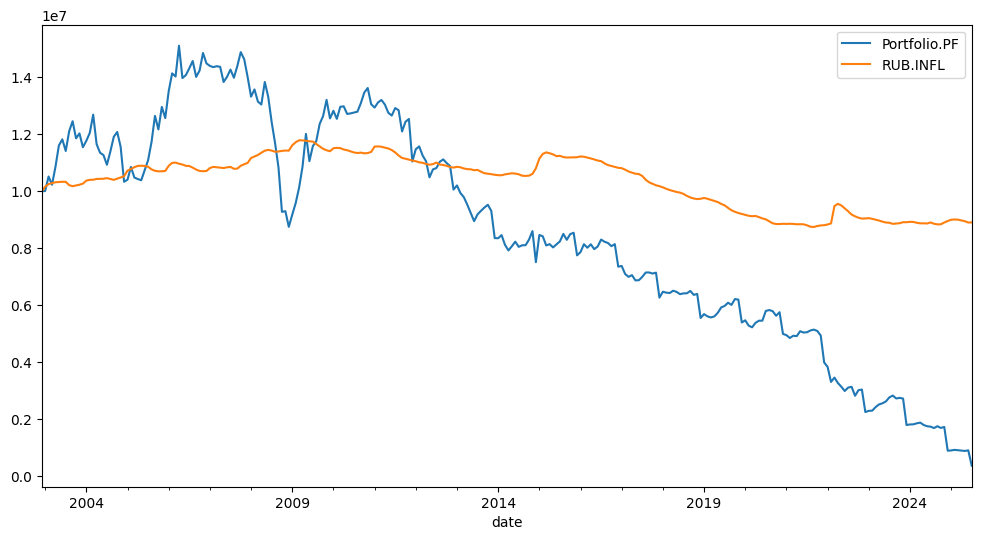

In [211]:
df2 = pf.dcf.wealth_index(discounting="pv", include_negative_values=False)
df2.plot()

In [147]:
df1 = pf.dcf.cash_flow_ts(discounting="pv", remove_if_wealth_index_negative=True)
df1[df1 != 0]

date
2003-12   -924,043.41589
2004-12   -924,043.41589
2005-12   -924,043.41589
2006-12   -924,043.41589
2007-12   -924,043.41589
2008-12   -924,043.41589
2009-12   -924,043.41589
2010-12   -924,043.41589
2011-12   -924,043.41589
2012-12   -924,043.41589
2013-12   -924,043.41589
2014-12   -924,043.41589
2015-12   -924,043.41589
2016-12   -924,043.41589
2017-12   -924,043.41589
2018-12   -924,043.41589
2019-12   -924,043.41589
2020-12   -924,043.41589
2021-12   -924,043.41589
2022-12   -924,043.41589
2023-12   -924,043.41589
2024-12   -924,043.41589
2025-07   -558,731.99971
Freq: M, Name: cashflow_ts, dtype: float64

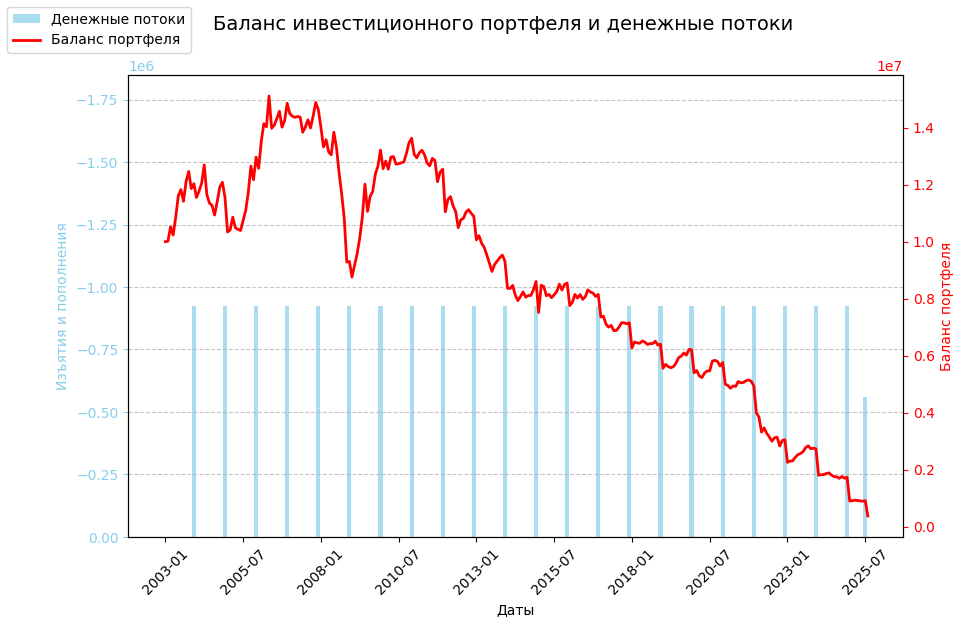

In [148]:
plot_wealth_with_cf(pf, discounting="pv")

<Axes: xlabel='date'>

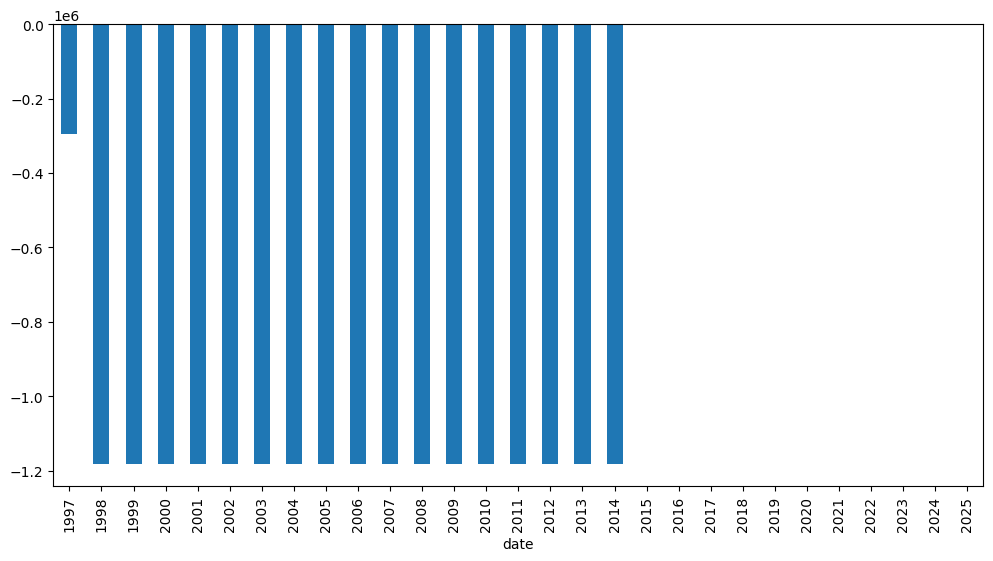

In [31]:
cf = pf.dcf.cash_flow_ts("pv", remove_if_wealth_index_negative=True)
cf.resample("Y").sum().plot(kind="bar")

<Axes: xlabel='date'>

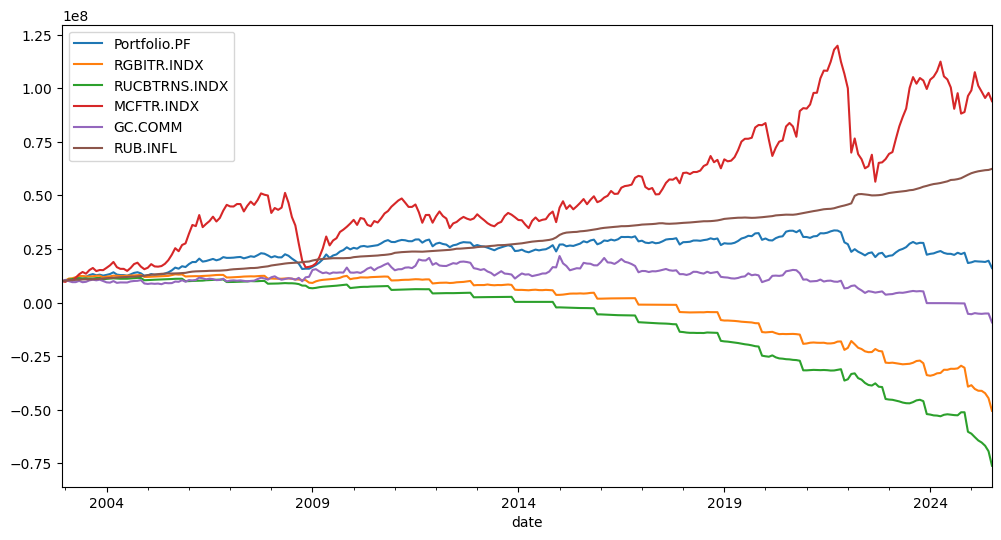

In [203]:
pf.dcf.wealth_index_fv_with_assets.plot()

In [204]:
pf.dcf.survival_period_hist()

22.6

#### Монте-Карло Indexation

In [245]:
pf.dcf.cashflow_parameters

Strategy name                                                              CWID
Portfolio symbol                                                   Portfolio.PF
Cash flow initial investment                                           10000000
Cash flow frequency                                                        year
Cash flow strategy                                                         CWID
Cash flow amount                                               -1,000,000.00000
Cash flow indexation                                                    0.09000
Crash threshold reduction       [(0.05, 0.2), (0.1, 0.4), (0.2, 0.5), (0.3, 1)]
dtype: object

In [238]:
pf.dcf._monte_carlo_wealth_fv

""


In [242]:
pf.dcf.set_mc_parameters(distribution="norm", period=100, number=1000)

In [243]:
df = pf.dcf.monte_carlo_wealth(discounting="fv", include_negative_values=False)

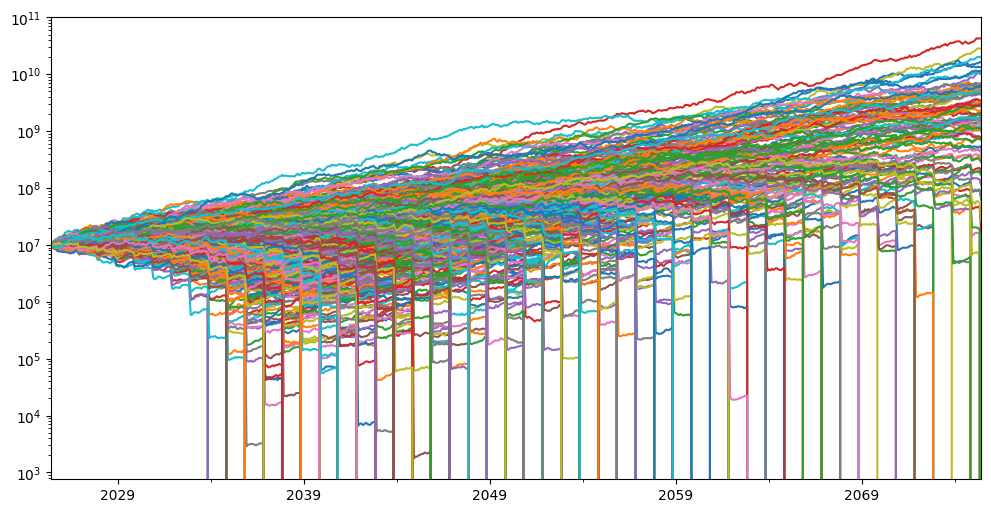

In [57]:
df.plot(legend=False)
plt.yscale('log')  # linear or log

In [244]:
sp = pf.dcf.monte_carlo_survival_period()
sp.describe([.05, .20, .30, .50, .70, .90])

count   1,000.00000
mean       19.13700
std        12.27442
min         8.50000
5%         10.50000
20%        12.50000
30%        13.50000
50%        16.50000
70%        19.50000
90%        26.50000
max       100.10000
dtype: float64

<Axes: ylabel='Frequency'>

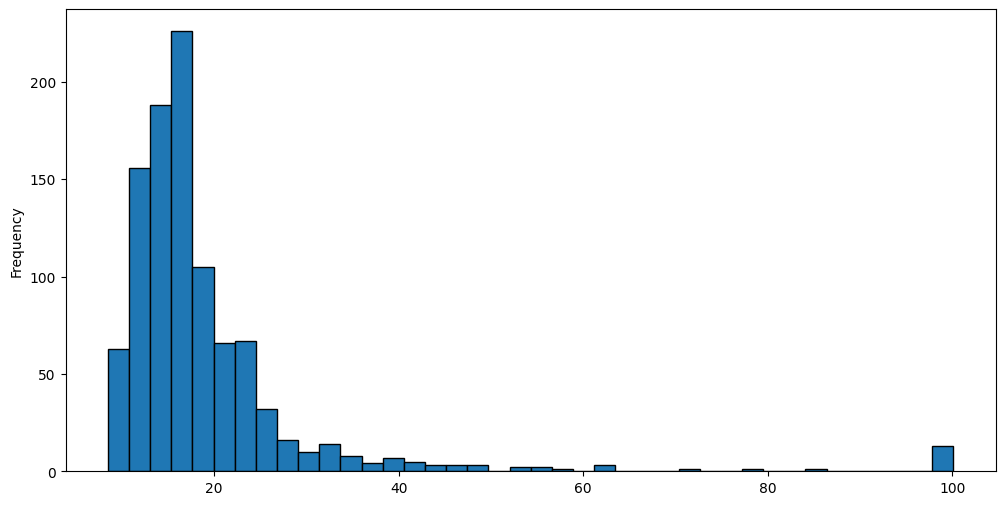

In [247]:
sp.plot(kind="hist", bins=40, edgecolor='black')

In [99]:
cf = pf.dcf.monte_carlo_cash_flow(discounting="pv", remove_if_wealth_index_negative=True)

<Axes: >

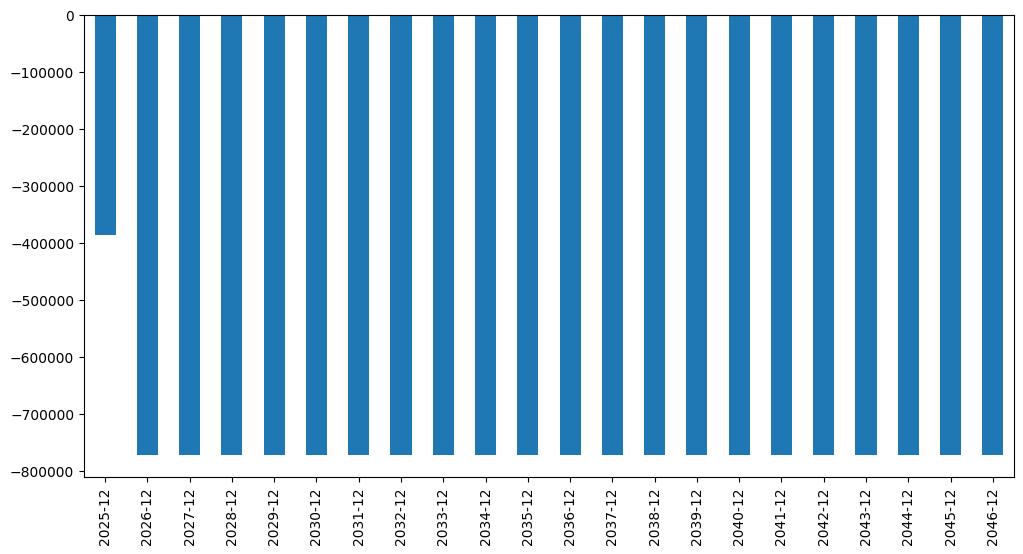

In [100]:
df = cf[0]
df[df != 0].plot(kind="bar")

In [101]:
df[df != 0]

2025-12   -385,891.85958
2026-12   -771,783.71915
2027-12   -771,783.71915
2028-12   -771,783.71915
2029-12   -771,783.71915
2030-12   -771,783.71915
2031-12   -771,783.71915
2032-12   -771,783.71915
2033-12   -771,783.71915
2034-12   -771,783.71915
2035-12   -771,783.71915
2036-12   -771,783.71915
2037-12   -771,783.71915
2038-12   -771,783.71915
2039-12   -771,783.71915
2040-12   -771,783.71915
2041-12   -771,783.71915
2042-12   -771,783.71915
2043-12   -771,783.71915
2044-12   -771,783.71915
2045-12   -771,783.71915
2046-12   -771,783.71915
Freq: M, Name: 0, dtype: float64

In [114]:
cf_year = cf.resample("Y").last()
cf_year

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2025,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958",...,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958"
2026,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2027,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2028,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2029,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2030,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2031,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2032,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2033,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"
2034,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915",...,"-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915","-771,783.71915"


In [115]:
cf_year.mean()

0    -638,205.76776
1    -742,753.23264
2    -742,753.23264
3    -742,753.23264
4    -281,997.89738
          ...      
95   -742,753.23264
96   -667,889.75696
97   -341,365.87578
98   -742,753.23264
99   -460,101.83257
Length: 100, dtype: float64

In [110]:
last = cf.iloc[-1]
last[last != 0]

1    -402,882.92933
2    -402,882.92933
3    -402,882.92933
11   -402,882.92933
13   -402,882.92933
16   -402,882.92933
17   -402,882.92933
18   -402,882.92933
25   -402,882.92933
26   -402,882.92933
28   -402,882.92933
29   -402,882.92933
33   -402,882.92933
37   -402,882.92933
38   -402,882.92933
43   -402,882.92933
44   -402,882.92933
47   -402,882.92933
49   -402,882.92933
53   -402,882.92933
55   -402,882.92933
59   -402,882.92933
60   -402,882.92933
64   -402,882.92933
66   -402,882.92933
67   -402,882.92933
70   -402,882.92933
71   -402,882.92933
72   -402,882.92933
73   -402,882.92933
74   -402,882.92933
75   -402,882.92933
83   -402,882.92933
86   -402,882.92933
90   -402,882.92933
95   -402,882.92933
98   -402,882.92933
Name: 2050-06, dtype: float64

<Axes: ylabel='Frequency'>

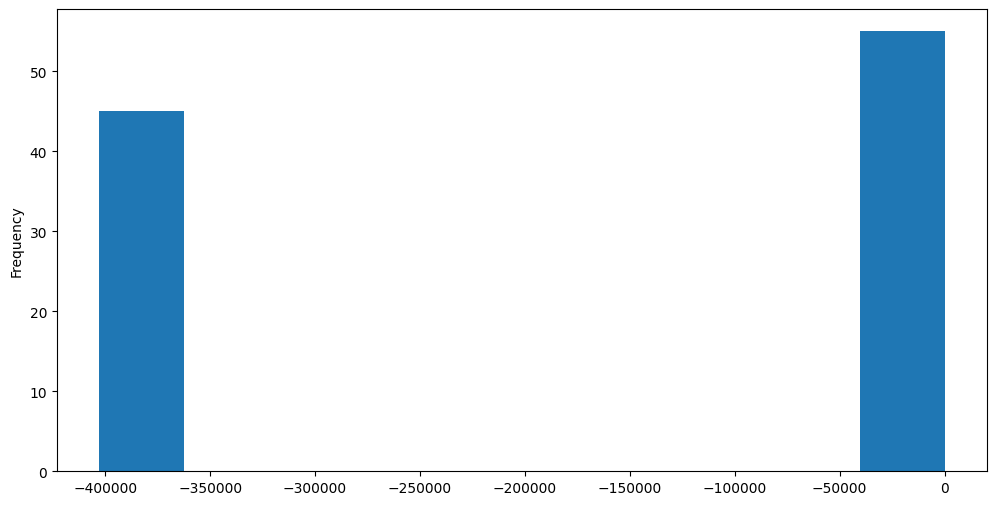

In [39]:
last.plot(kind="hist")

<Axes: ylabel='Frequency'>

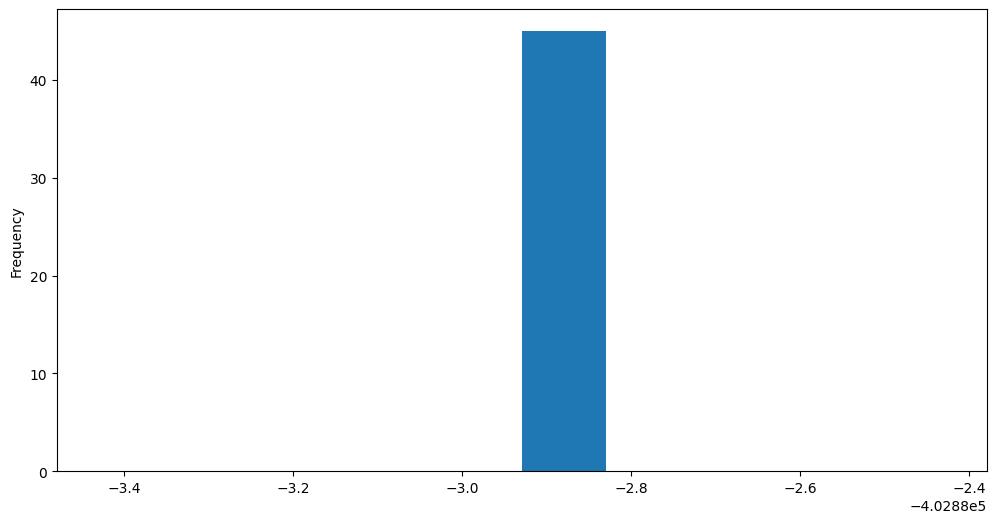

In [40]:
last[last !=0].plot(kind="hist")

<Axes: ylabel='Frequency'>

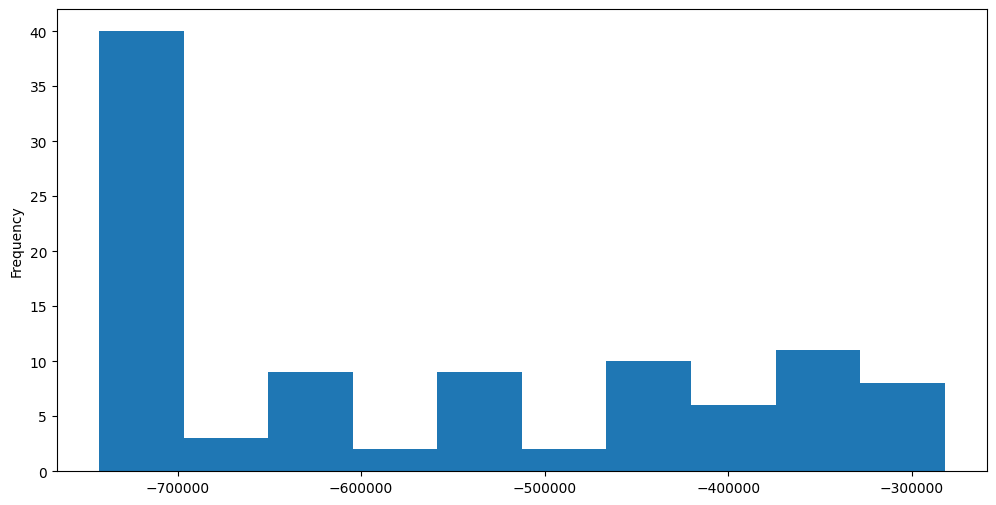

In [116]:
cf_year.mean().plot(kind="hist")

### Fixed Percentage

In [39]:
# Fixed Percentage strategy
pc = ok.PercentageStrategy(pf)
pc.initial_investment = 10_000_000
pc.frequency = "none"
pc.percentage = -0.08
pc

Strategy name                   fixed_percentage
Portfolio symbol                    Portfolio.PF
Cash flow initial investment            10000000
Cash flow frequency                         none
Cash flow strategy              fixed_percentage
Cash flow percentage                    -0.08000
dtype: object

In [40]:
# Assign a strategy
pf.dcf.cashflow_parameters = pc

In [41]:
print(pf.dcf)

Portfolio symbol                Portfolio.PF
Monte Carlo distribution                norm
Monte Carlo period                        25
Cash flow strategy          fixed_percentage
discount_rate                        0.09000
dtype: object


In [42]:
print(pf)

symbol                              Portfolio.PF
assets                              [MCFTR.INDX]
weights                                      [1]
rebalancing_period                          year
rebalancing_abs_deviation                   None
rebalancing_rel_deviation                   None
currency                                     RUB
inflation                               RUB.INFL
first_date                               1997-10
last_date                                2025-07
period_length                27 years, 10 months
dtype: object


In [44]:
pf.dcf.wealth_index("pv").plot()

KeyError: 'Portfolio.PF'

In [45]:
df = pf.dcf.cash_flow_ts("pv")
df[df != 0].plot(kind="bar")

ZeroDivisionError: division by zero

### Монте-Карло Percentage

In [126]:
pf.dcf.set_mc_parameters(distribution="norm", period=25, number=100)

In [127]:
sp = pf.dcf.monte_carlo_survival_period(threshold=.05)
sp.describe([.05, .10, .20, .50])

count   100.00000
mean     25.00000
std       0.00000
min      25.00000
5%       25.00000
10%      25.00000
20%      25.00000
50%      25.00000
max      25.00000
dtype: float64

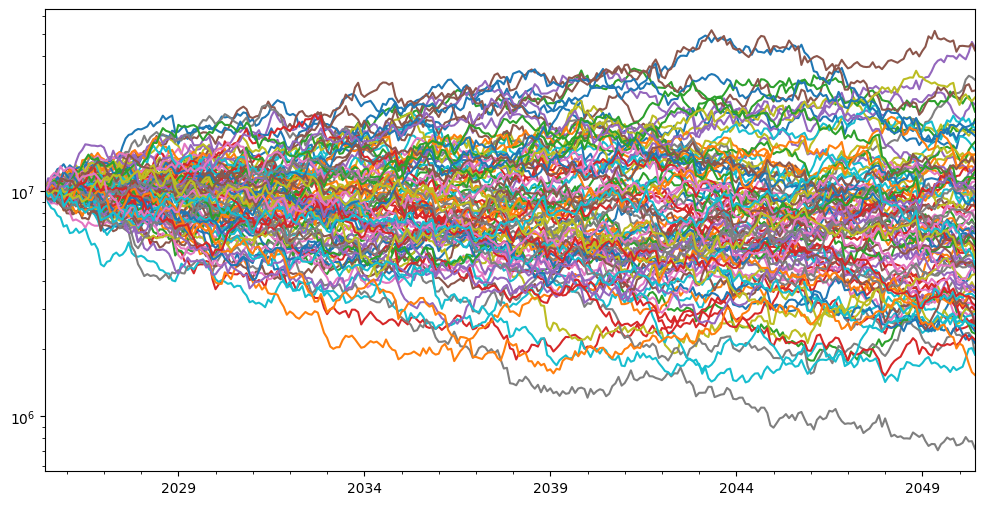

In [128]:
df = pf.dcf.monte_carlo_wealth("pv")
df.plot(legend=False)
plt.yscale('log')  # linear or log

In [129]:
cf = pf.dcf.monte_carlo_cash_flow(discounting="pv", remove_if_wealth_index_negative=True)

<Axes: >

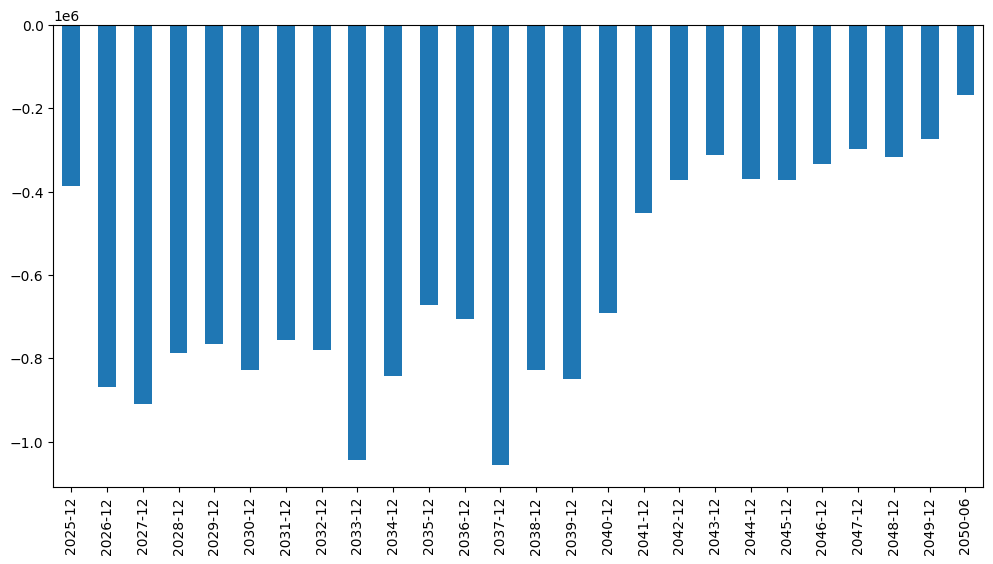

In [130]:
df = cf[0]
df[df != 0].plot(kind="bar")

In [134]:
cf_year = cf.resample("Y").last()
cf_year

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2025,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958",...,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958"
2026,"-867,837.17609","-677,274.78263","-698,106.47980","-704,139.73858","-633,421.21299","-652,324.65372","-753,582.48436","-785,388.56568","-810,380.88192","-634,050.17962",...,"-945,617.24469","-678,360.44359","-695,596.32046","-726,638.24490","-673,753.73319","-902,740.39838","-716,182.67122","-827,812.79209","-800,090.89923","-745,500.95556"
2027,"-910,138.48782","-688,514.21011","-625,295.98287","-721,360.98257","-688,987.15898","-766,615.88567","-829,541.13060","-823,335.18937","-694,914.34958","-560,355.72568",...,"-883,673.05460","-765,536.67630","-597,307.66957","-574,576.40642","-618,041.12052","-895,550.34137","-848,454.62327","-912,848.20541","-813,529.68702","-581,060.60962"
2028,"-787,803.52429","-619,013.05116","-484,120.53692","-608,689.36084","-720,220.48860","-973,609.68225","-965,196.73120","-1,009,146.57291","-503,731.05065","-455,891.48738",...,"-906,538.46991","-646,057.99945","-549,983.59196","-622,658.25156","-589,210.37389","-1,182,922.60131","-519,795.20525","-904,868.03062","-881,281.13175","-592,638.40787"
2029,"-765,218.19155","-601,966.50876","-414,585.14515","-556,633.61558","-715,025.86811","-1,151,314.07502","-962,546.67731","-841,934.44645","-469,355.61986","-343,812.68675",...,"-964,603.03445","-699,950.24693","-513,590.83518","-660,818.00085","-478,283.31686","-1,090,711.50009","-632,365.45586","-772,261.01920","-688,716.66365","-445,373.65785"
2030,"-828,428.01010","-655,506.52160","-462,440.36389","-507,258.81854","-647,408.74491","-1,207,405.66833","-954,921.97433","-882,593.11676","-480,239.77495","-301,386.10446",...,"-1,138,535.32492","-776,220.59784","-480,128.66566","-587,959.44668","-558,262.77995","-1,136,660.68404","-643,812.51993","-802,226.20094","-690,127.66307","-437,093.80474"
2031,"-755,581.37446","-817,595.41431","-511,729.30034","-522,744.95973","-574,982.55037","-1,282,247.62398","-693,557.67171","-896,622.66157","-469,282.31287","-282,394.88077",...,"-896,243.04326","-591,882.31931","-352,709.16131","-572,347.53161","-537,329.46400","-1,014,158.74446","-751,886.53372","-899,465.30490","-754,408.85909","-372,310.32783"
2032,"-778,764.90856","-764,294.76093","-437,380.81306","-636,210.59223","-582,783.89677","-1,177,723.99384","-733,639.00774","-1,093,445.25720","-412,566.71738","-192,104.62192",...,"-852,649.23289","-632,459.90268","-322,152.80385","-604,138.07821","-510,811.66974","-1,047,722.17626","-917,032.95516","-645,685.70825","-683,728.78559","-345,329.10127"
2033,"-1,043,989.42788","-699,187.46039","-421,574.54352","-522,743.23183","-608,272.17495","-1,141,512.35262","-713,407.15869","-949,592.19734","-368,489.23159","-204,124.18925",...,"-893,004.41184","-607,726.61386","-320,814.69836","-684,191.96275","-529,633.68246","-958,376.20366","-924,166.80165","-641,429.93175","-779,874.69051","-315,505.21018"
2034,"-843,147.60587","-661,598.86131","-323,573.36094","-550,804.43347","-507,857.89994","-970,381.00549","-576,927.95893","-993,225.22587","-390,555.99788","-142,061.71239",...,"-908,614.02414","-624,288.68407","-286,280.20575","-675,923.61452","-479,903.14879","-961,647.20307","-841,853.83576","-512,568.53104","-627,269.64450","-247,211.76788"


In [135]:
cf_end = cf_year.iloc[-2]
cf_end.describe([.05, .20, .40, .70, .90])

count          100.00000
mean      -621,730.49137
std        557,741.14766
min     -3,638,224.61600
5%      -1,505,204.31201
20%       -855,755.92841
40%       -621,190.19703
50%       -472,366.62908
70%       -293,440.95600
90%       -194,216.42812
max        -60,907.04975
Name: 2049, dtype: float64

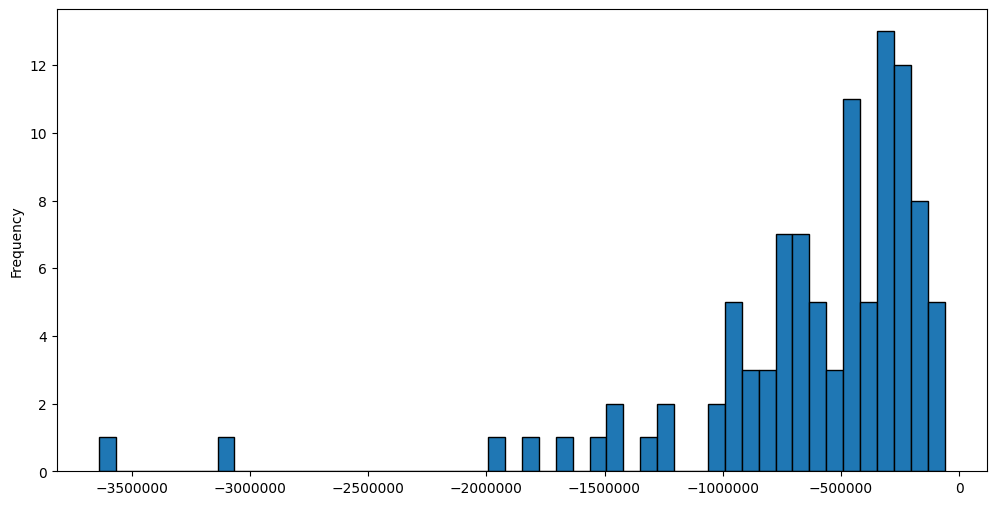

In [136]:
cf_end.plot(kind="hist", bins=50, edgecolor='black')
plt.ticklabel_format(style='plain', axis='x')

In [138]:
cf_year.mean().describe()

count          100.00000
mean      -664,507.54498
std        316,183.45729
min     -1,978,801.34091
25%       -836,266.93110
50%       -588,344.37679
75%       -467,948.41032
max       -187,142.10828
dtype: float64

<Axes: ylabel='Frequency'>

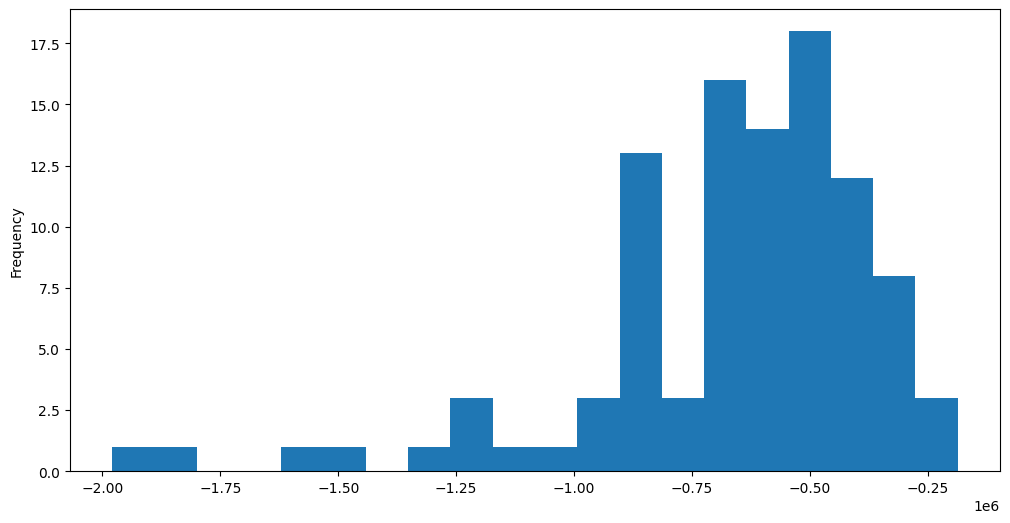

In [139]:
cf_year.mean().plot(kind="hist", bins=20)

<Axes: ylabel='Frequency'>

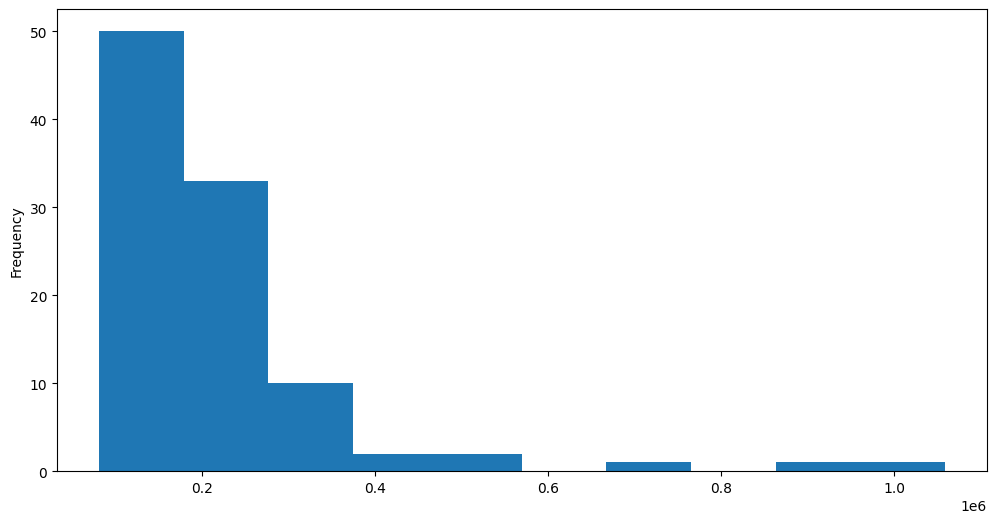

In [141]:
cf_year.std().plot(kind="hist")

In [142]:
cf_year.std().describe()

count         100.00000
mean      222,677.05853
std       148,159.64357
min        80,620.89009
25%       147,957.20615
50%       178,904.82526
75%       245,900.19144
max     1,058,228.00141
dtype: float64

### TimeSeries strategy

In [38]:
d = {
    "2025-02": 1_000,
    "2029-03": -2_000,
}

d1 = {
    "2018-02": 2_000,
    "2024-03": -4_000,
}

ts = ok.TimeSeriesStrategy(pf)
ts.initial_investment = 1_000
ts.time_series_dic = d1

print(ts)

Strategy name                    time_series
Portfolio symbol                Portfolio.PF
Cash flow initial investment            1000
Cash flow strategy               time_series
dtype: object


In [33]:
# Assign a strategy
pf.dcf.cashflow_parameters = ts

In [34]:
pf.dcf

Portfolio symbol            Portfolio.PF
Monte Carlo distribution            norm
Monte Carlo period                    25
Cash flow strategy           time_series
discount_rate                    0.09000
dtype: object

In [8]:
# Set Monte Carlo
pf.dcf.set_mc_parameters(distribution="t", period=10, number=100)

In [14]:
pf.dcf.mc.period = 10

In [9]:
pf.dcf.mc.period

14

In [20]:
pf.dcf.cash_flow_parameters

AttributeError: 'PortfolioDCF' object has no attribute 'cash_flow_parameters'

In [36]:
pf.dcf.initial_investment_fv

8623.080660403197

<Axes: >

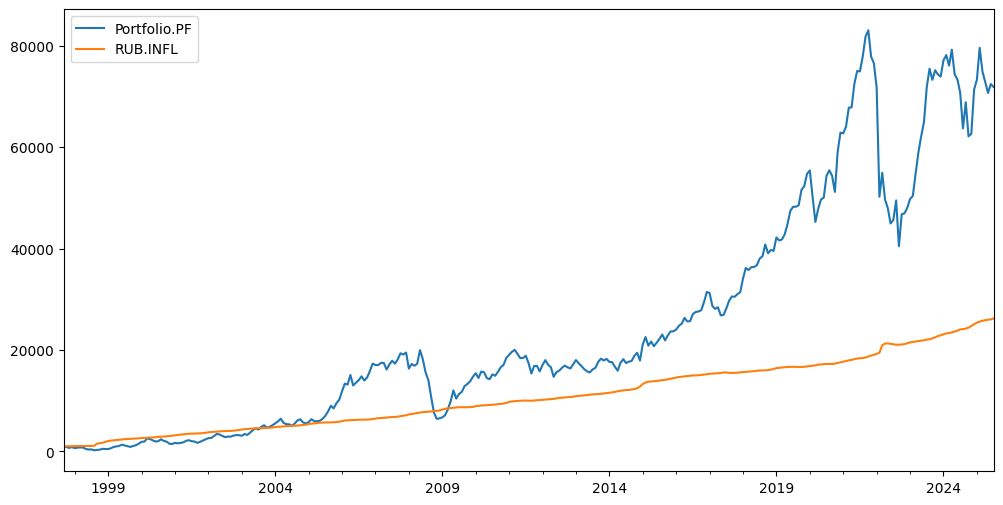

In [37]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot()

In [9]:
df = pf.dcf.monte_carlo_wealth_pv

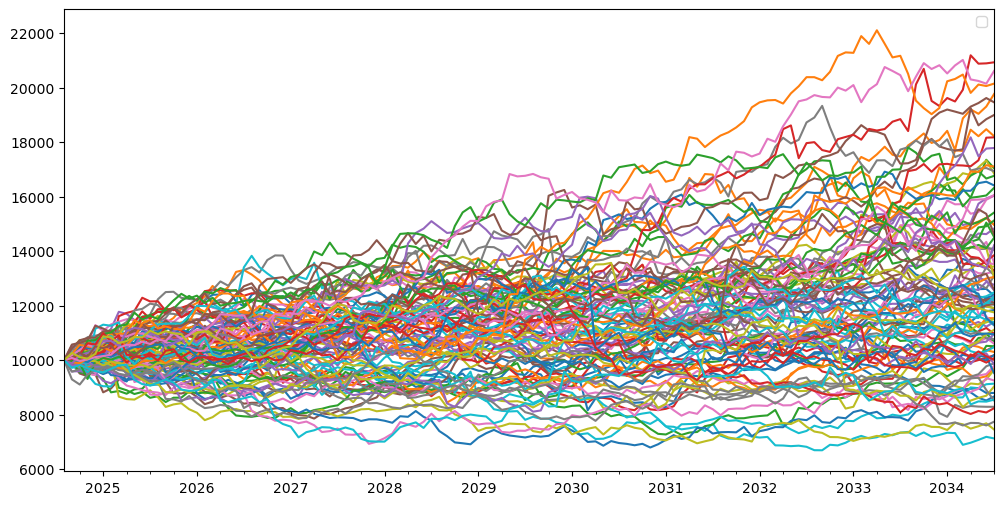

In [11]:
df.plot()
plt.legend("")

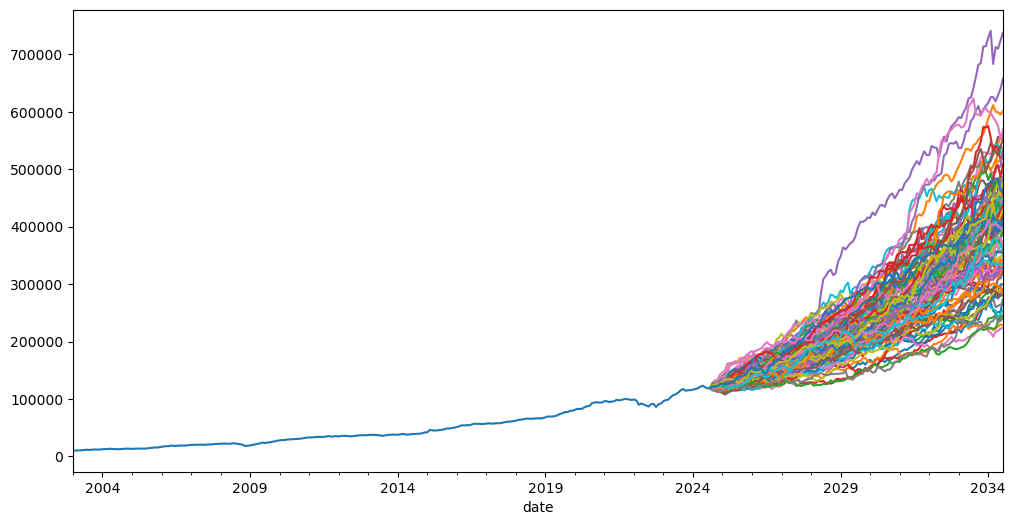

In [13]:
pf.dcf.plot_forecast_monte_carlo(backtest=True)

### Vanguard Dynamic Spending (VDS)

In [83]:
x = ok.VanguardDynamicSpending(pf)

In [84]:
print(x)

Strategy name                                   VDS
Portfolio symbol                       Portfolio.PF
Cash flow initial investment            1,000.00000
Cash flow frequency                            year
Cash flow strategy                              VDS
Cash flow percentage                        0.00000
Minimum annual withdrawal                      None
Maximum annual withdrawal                      None
Max and Min withdrawals are indexed            True
Floor                                          None
Ceiling                                        None
Floor and Ceiling are indexed                 False
Indexation                                     None
dtype: object


In [79]:
# Fixed Percentage strategy
vds = ok.VanguardDynamicSpending(pf)
vds.initial_investment = 1_000_000
vds.frequency = "year"
vds.percentage = -0.08
vds.indexation = 0.09
vds.min_max_annual_withdrawals = 1_000_000 / 25, 1_000_000 / 10   # 10% , 4%
vds.adjust_min_max = True
vds.floor_ceiling = -0.10, 0.20
vds.adjust_floor_ceiling = False

In [61]:
print(vds)

Portfolio symbol                       Portfolio.PF
Cash flow initial investment                1000000
Cash flow frequency                            year
Cash flow strategy                              VDS
Cash flow percentage                       -0.08000
Minimum annual withdrawal              40,000.00000
Maximum annual withdrawal             100,000.00000
Max and Min withdrawals are indexed            True
Floor                                      -0.10000
Ceiling                                     0.20000
Floor and Ceiling are indexed                  True
Indexation                                  0.09000
dtype: object


In [62]:
pf.dcf.cashflow_parameters = vds

In [68]:
wi = pf.dcf.wealth_index(discounting="pv", include_negative_values=False)
cf = pf.dcf.cash_flow_ts(discounting="pv", remove_if_wealth_index_negative=True).resample("Y").sum()

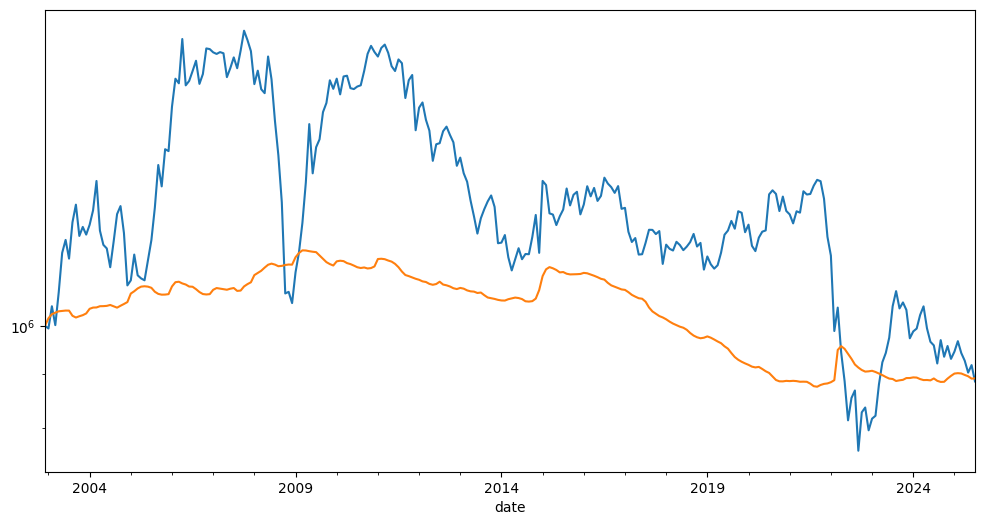

In [69]:
wi.plot(legend=False)
plt.yscale('log')  # linear or log

In [70]:
cf

date
2003   -73,923.47327
2004   -88,708.16793
2005   -80,867.56998
2006   -92,404.34159
2007   -92,404.34159
2008   -92,404.34159
2009   -83,163.90743
2010   -92,404.34159
2011   -92,404.34159
2012   -92,404.34159
2013   -92,404.34159
2014   -88,388.89600
2015   -86,550.27281
2016   -92,404.34159
2017   -92,404.34159
2018   -84,457.21061
2019   -83,406.22154
2020   -90,521.03900
2021   -92,404.34159
2022   -89,590.79006
2023   -80,631.71105
2024   -72,568.53995
2025   -40,444.93954
Freq: Y-DEC, Name: cashflow_ts, dtype: float64

In [71]:
cf.pct_change()

date
2003        NaN
2004    0.20000
2005   -0.08839
2006    0.14266
2007    0.00000
2008   -0.00000
2009   -0.10000
2010    0.11111
2011   -0.00000
2012   -0.00000
2013   -0.00000
2014   -0.04346
2015   -0.02080
2016    0.06764
2017   -0.00000
2018   -0.08600
2019   -0.01244
2020    0.08530
2021    0.02081
2022   -0.03045
2023   -0.10000
2024   -0.10000
2025   -0.44267
Freq: Y-DEC, Name: cashflow_ts, dtype: float64

<Axes: xlabel='date'>

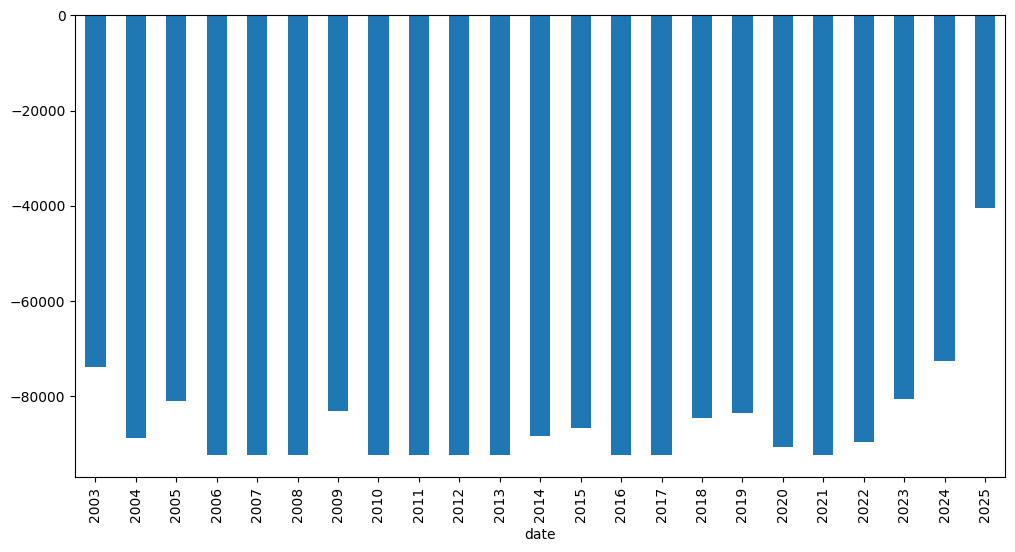

In [72]:
cf.plot(
    kind="bar",
    legend=False
    )

#### VDS Monte Carlo

In [100]:
pf.dcf.set_mc_parameters(
    distribution="norm",
    period=25,
    number=1000
)

In [ ]:
wi = pf.dcf.monte_carlo_wealth(discounting="pv", include_negative_values=False)
cf = pf.dcf.monte_carlo_cash_flow(discounting="pv", remove_if_wealth_index_negative=True)

In [103]:
sp = pf.dcf.monte_carlo_survival_period()
sp.describe([.05, .20, .30, .50])

count   1,000.00000
mean       25.00000
std         0.00000
min        25.00000
5%         25.00000
20%        25.00000
30%        25.00000
50%        25.00000
max        25.00000
dtype: float64

In [ ]:
df = cf[2]
df[df != 0].plot(
    kind="bar",
    legend=False
    )

In [172]:
cf_year = cf.resample("Y").last()
cf_year

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2025,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958",...,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958"
2026,"-900,088.65950","-727,868.79193","-906,306.30891","-640,591.55464","-663,845.33364","-653,204.50368","-818,584.20378","-656,530.24003","-756,862.54936","-591,901.23557",...,"-614,355.11224","-522,283.39893","-727,161.27300","-651,962.25828","-698,397.07778","-722,778.80880","-832,712.87186","-816,711.59440","-886,202.80393","-792,826.52341"
2027,"-949,860.88727","-824,314.00813","-821,425.16983","-654,995.97732","-633,518.85669","-858,337.90047","-964,729.64894","-920,927.75183","-886,111.15120","-534,289.77301",...,"-507,705.13802","-411,269.25331","-632,799.32856","-531,600.80325","-786,710.19466","-652,887.99413","-665,901.15904","-964,729.64894","-945,731.96349","-887,592.45399"
2028,"-964,729.64894","-913,233.96137","-708,176.77014","-759,838.86513","-508,061.95522","-843,328.62163","-964,729.64894","-964,729.64894","-854,999.92831","-664,366.85620",...,"-561,722.55184","-412,245.89094","-872,355.29413","-385,891.85958","-758,169.07471","-526,057.85683","-673,877.26730","-920,601.67935","-880,739.50550","-964,729.64894"
2029,"-920,898.01824","-884,112.19922","-653,814.92895","-939,616.42302","-463,809.24589","-964,729.64894","-964,729.64894","-883,206.02463","-811,877.90827","-667,430.98346",...,"-533,815.60254","-487,483.55689","-689,132.64162","-385,891.85958","-789,493.20490","-599,088.76137","-494,712.30984","-964,729.64894","-634,211.50082","-964,729.64894"
2030,"-848,758.00544","-964,729.64894","-646,900.90796","-899,977.69484","-385,891.85958","-964,729.64894","-953,067.06101","-718,060.23717","-848,492.21987","-562,126.13697",...,"-563,087.70058","-432,455.82628","-765,091.89844","-385,891.85958","-667,081.81083","-610,517.25511","-403,843.62177","-964,729.64894","-629,766.58076","-964,729.64894"
2031,"-828,977.16147","-963,352.99926","-709,289.60989","-964,729.64894","-388,684.12722","-964,729.64894","-845,962.80721","-582,325.30725","-638,322.27120","-591,497.54966",...,"-506,893.54511","-385,891.85958","-924,888.09285","-385,891.85958","-707,020.97587","-566,218.60427","-517,406.13720","-884,987.25617","-494,675.68246","-964,729.64894"
2032,"-964,729.64894","-933,160.95483","-913,464.78164","-964,729.64894","-385,891.85958","-964,729.64894","-787,490.08327","-524,992.08025","-698,885.94922","-431,921.52976",...,"-512,632.60572","-385,891.85958","-964,729.64894","-385,891.85958","-773,328.15216","-525,298.24456","-607,279.41439","-926,477.15291","-537,864.11789","-964,729.64894"
2033,"-964,729.64894","-754,134.64789","-964,729.64894","-964,729.64894","-385,891.85958","-954,896.13919","-695,436.00972","-525,165.29015","-655,778.87672","-422,150.23876",...,"-529,059.04092","-385,891.85958","-964,729.64894","-385,891.85958","-567,324.71918","-543,940.25143","-551,657.80882","-859,500.33086","-488,191.07366","-964,729.64894"
2034,"-964,729.64894","-585,813.65825","-964,729.64894","-964,729.64894","-385,891.85958","-762,282.38965","-698,420.71108","-442,836.61807","-621,264.88664","-439,469.99776",...,"-587,795.04845","-385,891.85958","-890,758.17549","-385,891.85958","-591,351.21816","-520,777.79490","-484,133.60678","-658,815.94565","-422,766.59781","-964,729.64894"


In [173]:
last = cf_year.iloc[-2]
last[last != 0].describe([.05, .20, .30, .50, .70, .90])

count        893.00000
mean    -614,659.10979
std      241,523.08275
min     -964,729.64894
5%      -964,729.64894
20%     -964,729.64894
30%     -797,499.12320
50%     -516,636.45691
70%     -385,891.85958
90%     -385,891.85958
max     -385,891.85958
Name: 2049, dtype: float64

<Axes: ylabel='Frequency'>

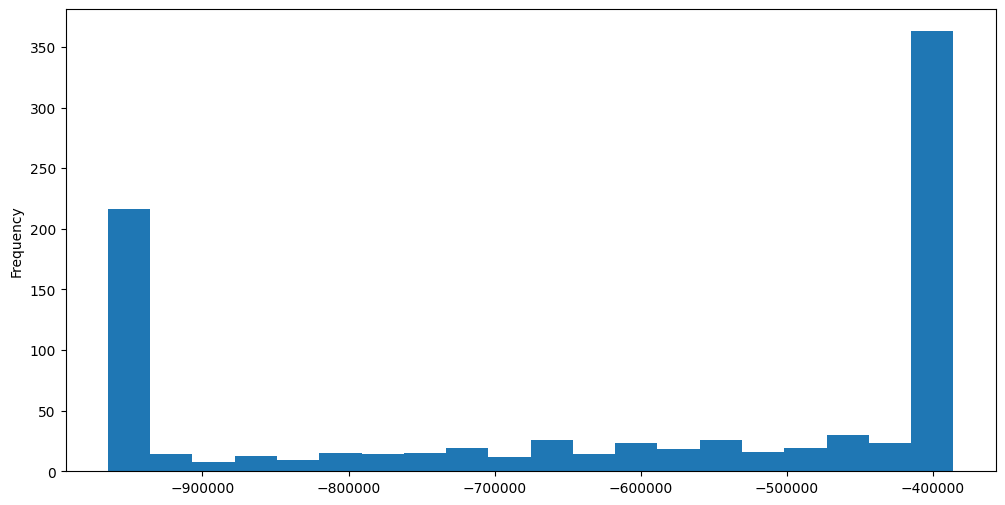

In [174]:
last[last != 0].plot(kind="hist", bins=20)

<Axes: ylabel='Frequency'>

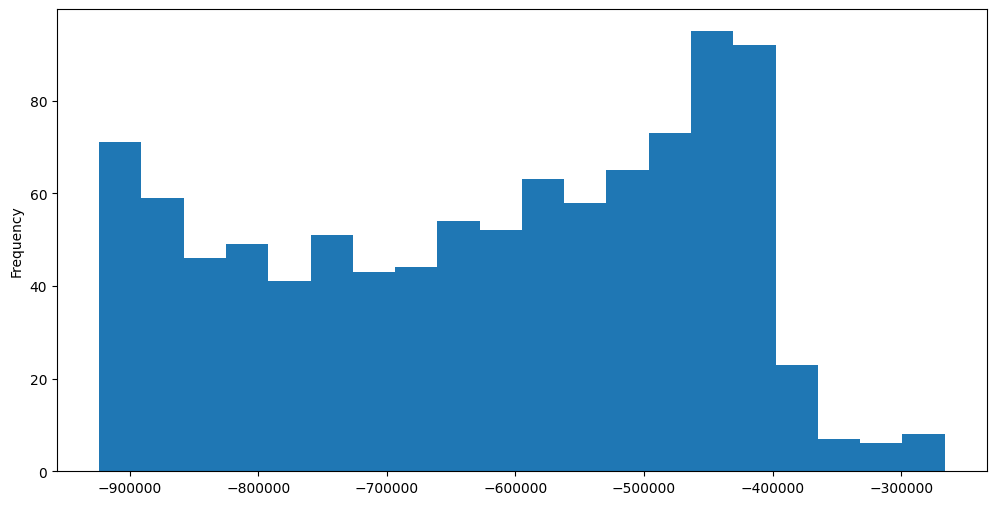

In [175]:
cf_year.mean().plot(kind="hist", bins=20)

In [162]:
cf_year.mean().describe()

count        100.00000
mean    -627,139.37957
std      176,120.27073
min     -921,897.40943
25%     -788,224.51884
50%     -587,997.63493
75%     -488,782.42938
max     -273,078.68941
dtype: float64

In [166]:
cf_year.std().describe()

count       100.00000
mean    165,213.46899
std      51,823.26765
min      67,942.57851
25%     136,876.01258
50%     154,672.44115
75%     187,218.42847
max     362,382.25566
dtype: float64

In [176]:
cf_year_survived = cf_year[cf_year.iloc[-1] != 0]
cf_year_survived

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [182]:
cf_year_survived = cf_year.loc[:, cf_year.iloc[-1] != 0]
cf_year_survived

,0,1,2,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
2025,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958",...,"-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958","-385,891.85958"
2026,"-900,088.65950","-727,868.79193","-906,306.30891","-663,845.33364","-653,204.50368","-818,584.20378","-656,530.24003","-756,862.54936","-591,901.23557","-658,827.82842",...,"-614,355.11224","-522,283.39893","-727,161.27300","-651,962.25828","-698,397.07778","-722,778.80880","-832,712.87186","-816,711.59440","-886,202.80393","-792,826.52341"
2027,"-949,860.88727","-824,314.00813","-821,425.16983","-633,518.85669","-858,337.90047","-964,729.64894","-920,927.75183","-886,111.15120","-534,289.77301","-772,226.31794",...,"-507,705.13802","-411,269.25331","-632,799.32856","-531,600.80325","-786,710.19466","-652,887.99413","-665,901.15904","-964,729.64894","-945,731.96349","-887,592.45399"
2028,"-964,729.64894","-913,233.96137","-708,176.77014","-508,061.95522","-843,328.62163","-964,729.64894","-964,729.64894","-854,999.92831","-664,366.85620","-453,406.56596",...,"-561,722.55184","-412,245.89094","-872,355.29413","-385,891.85958","-758,169.07471","-526,057.85683","-673,877.26730","-920,601.67935","-880,739.50550","-964,729.64894"
2029,"-920,898.01824","-884,112.19922","-653,814.92895","-463,809.24589","-964,729.64894","-964,729.64894","-883,206.02463","-811,877.90827","-667,430.98346","-385,891.85958",...,"-533,815.60254","-487,483.55689","-689,132.64162","-385,891.85958","-789,493.20490","-599,088.76137","-494,712.30984","-964,729.64894","-634,211.50082","-964,729.64894"
2030,"-848,758.00544","-964,729.64894","-646,900.90796","-385,891.85958","-964,729.64894","-953,067.06101","-718,060.23717","-848,492.21987","-562,126.13697","-434,613.91021",...,"-563,087.70058","-432,455.82628","-765,091.89844","-385,891.85958","-667,081.81083","-610,517.25511","-403,843.62177","-964,729.64894","-629,766.58076","-964,729.64894"
2031,"-828,977.16147","-963,352.99926","-709,289.60989","-388,684.12722","-964,729.64894","-845,962.80721","-582,325.30725","-638,322.27120","-591,497.54966","-389,621.53907",...,"-506,893.54511","-385,891.85958","-924,888.09285","-385,891.85958","-707,020.97587","-566,218.60427","-517,406.13720","-884,987.25617","-494,675.68246","-964,729.64894"
2032,"-964,729.64894","-933,160.95483","-913,464.78164","-385,891.85958","-964,729.64894","-787,490.08327","-524,992.08025","-698,885.94922","-431,921.52976","-619,349.48858",...,"-512,632.60572","-385,891.85958","-964,729.64894","-385,891.85958","-773,328.15216","-525,298.24456","-607,279.41439","-926,477.15291","-537,864.11789","-964,729.64894"
2033,"-964,729.64894","-754,134.64789","-964,729.64894","-385,891.85958","-954,896.13919","-695,436.00972","-525,165.29015","-655,778.87672","-422,150.23876","-534,149.41390",...,"-529,059.04092","-385,891.85958","-964,729.64894","-385,891.85958","-567,324.71918","-543,940.25143","-551,657.80882","-859,500.33086","-488,191.07366","-964,729.64894"
2034,"-964,729.64894","-585,813.65825","-964,729.64894","-385,891.85958","-762,282.38965","-698,420.71108","-442,836.61807","-621,264.88664","-439,469.99776","-540,282.89347",...,"-587,795.04845","-385,891.85958","-890,758.17549","-385,891.85958","-591,351.21816","-520,777.79490","-484,133.60678","-658,815.94565","-422,766.59781","-964,729.64894"


<Axes: ylabel='Frequency'>

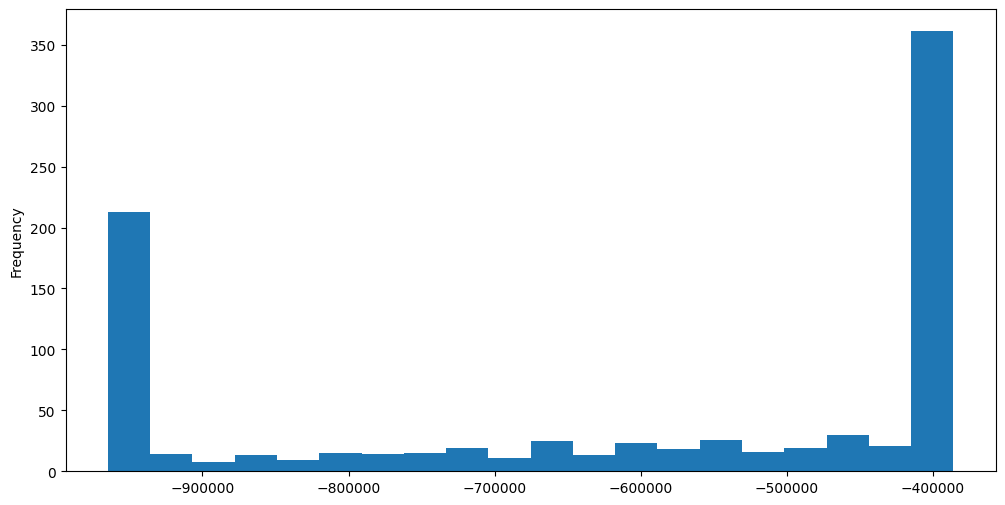

In [184]:
last = cf_year_survived.iloc[-2]
last.plot(kind="hist", bins=20)

In [185]:
last.describe()

count        883.00000
mean    -614,259.75167
std      241,620.93791
min     -964,729.64894
25%     -913,645.67832
50%     -513,727.54278
75%     -385,891.85958
max     -385,891.85958
Name: 2049, dtype: float64

<Axes: ylabel='Frequency'>

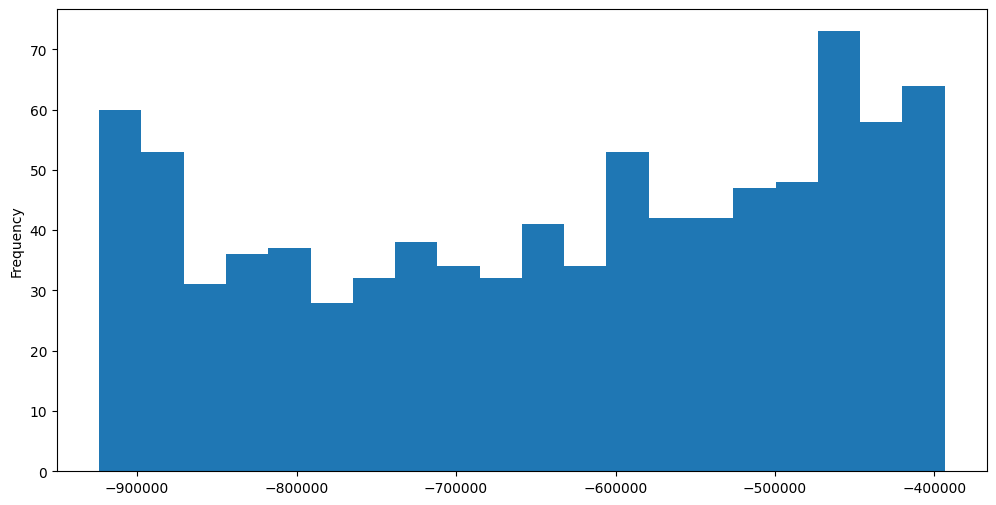

In [187]:
cf_year_survived.mean().plot(kind="hist", bins=20)

In [189]:
cf_year_survived.std().describe()

count       883.00000
mean    153,660.43550
std      39,430.42188
min      52,358.32652
25%     131,488.43085
50%     155,068.56441
75%     176,923.03829
max     271,777.19669
dtype: float64

### CutWithdrawalsIfDrawdown (CWID)

In [252]:
cwid = ok.CutWithdrawalsIfDrawdown(pf)

In [253]:
print(cwid)

Strategy name                                     CWID
Portfolio symbol                          Portfolio.PF
Cash flow initial investment               1,000.00000
Cash flow frequency                               year
Cash flow strategy                                CWID
Cash flow amount                               0.00000
Cash flow indexation                              None
Crash threshold reduction       [(0.2, 0.4), (0.5, 1)]
dtype: object


In [254]:
cwid.initial_investment = 10_000_000
cwid.frequency = "year"
cwid.amount = -10_000_000 * 0.10
cwid.indexation = 0.09

cwid.crash_threshold_reduction = [
    (.05, .20),
    (.10, .40),
    (.20, .50),
    (.30, 1)
]

# cwid.crash_threshold_reduction = [
#     (.20, .20),
#     (.40, .50),
#     (.60, .80),
# ]

In [255]:
pf.dcf.cashflow_parameters = cwid
print(cwid)

Strategy name                                                              CWID
Portfolio symbol                                                   Portfolio.PF
Cash flow initial investment                                           10000000
Cash flow frequency                                                        year
Cash flow strategy                                                         CWID
Cash flow amount                                               -1,000,000.00000
Cash flow indexation                                                    0.09000
Crash threshold reduction       [(0.05, 0.2), (0.1, 0.4), (0.2, 0.5), (0.3, 1)]
dtype: object


In [222]:
pf.drawdowns.resample("Y").last().nsmallest(10)

date
2008   -0.26489
2022   -0.15573
2004   -0.05518
2011   -0.04147
2021   -0.02499
2013   -0.01632
2014   -0.01278
2023   -0.01239
2003    0.00000
2005    0.00000
Freq: Y-DEC, Name: Portfolio.PF, dtype: float64

In [188]:
wi = pf.dcf.wealth_index(discounting="pv", include_negative_values=False)
cf = pf.dcf.cash_flow_ts(discounting="pv", remove_if_wealth_index_negative=True).resample("Y").sum()
# cf = pf.dcf.cash_flow_ts(discounting="pv", remove_if_wealth_index_negative=True)

In [189]:
cf

date
2003   -924,043.41589
2004   -739,234.73271
2005   -924,043.41589
2006   -924,043.41589
2007   -924,043.41589
2008   -462,021.70794
2009   -924,043.41589
2010   -924,043.41589
2011   -924,043.41589
2012   -924,043.41589
2013   -924,043.41589
2014   -924,043.41589
2015   -924,043.41589
2016   -924,043.41589
2017   -924,043.41589
2018   -924,043.41589
2019   -924,043.41589
2020   -924,043.41589
2021   -924,043.41589
2022   -554,426.04953
2023   -924,043.41589
2024   -924,043.41589
2025   -558,731.99971
Freq: Y-DEC, Name: cashflow_ts, dtype: float64

<Axes: xlabel='date'>

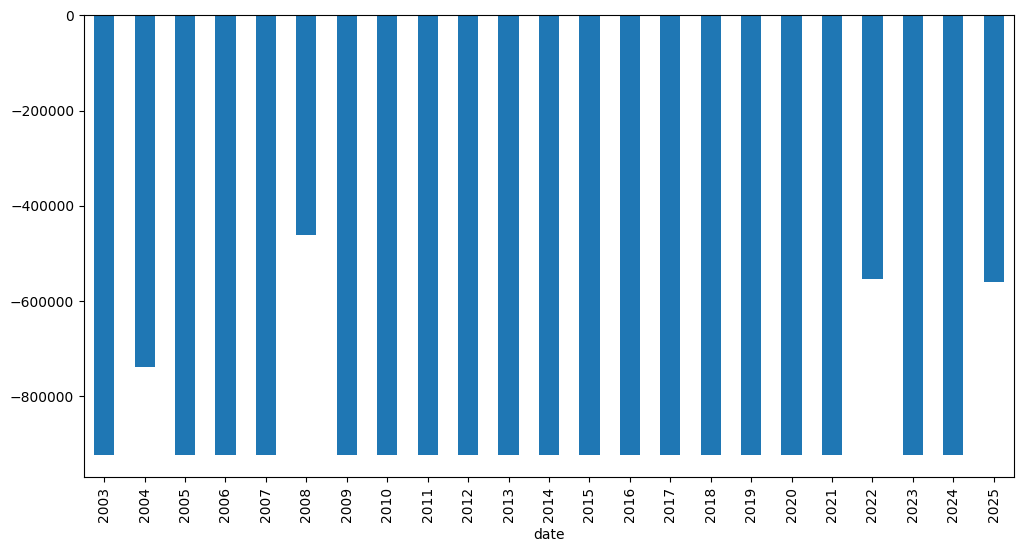

In [190]:
cf.plot(kind="bar", legend=False)

In [191]:
cf.mean()

np.float64(-863966.9300755349)

<Axes: xlabel='date'>

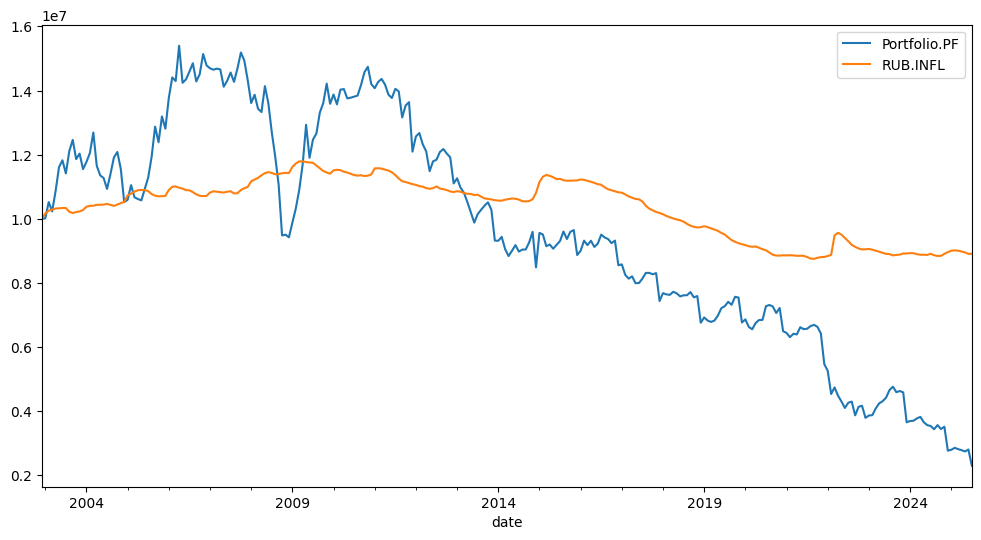

In [192]:
wi.plot()

In [193]:
pf.dcf.survival_period_hist()

22.6

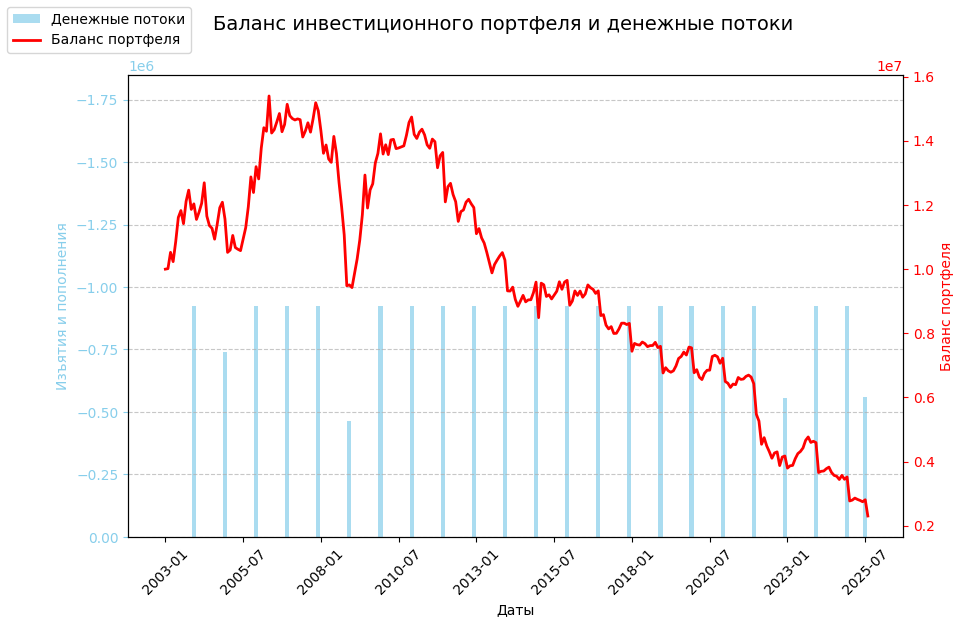

In [194]:
plot_wealth_with_cf(pf, discounting="pv")

#### Monte Carlo CWID

In [256]:
pf.dcf.cashflow_parameters

Strategy name                                                              CWID
Portfolio symbol                                                   Portfolio.PF
Cash flow initial investment                                           10000000
Cash flow frequency                                                        year
Cash flow strategy                                                         CWID
Cash flow amount                                               -1,000,000.00000
Cash flow indexation                                                    0.09000
Crash threshold reduction       [(0.05, 0.2), (0.1, 0.4), (0.2, 0.5), (0.3, 1)]
dtype: object

In [257]:
pf.dcf._monte_carlo_cash_flow_fv

""


In [258]:
pf.dcf.set_mc_parameters(distribution="norm", period=100, number=1000)

In [259]:
df = pf.dcf.monte_carlo_wealth(discounting="fv", include_negative_values=False)

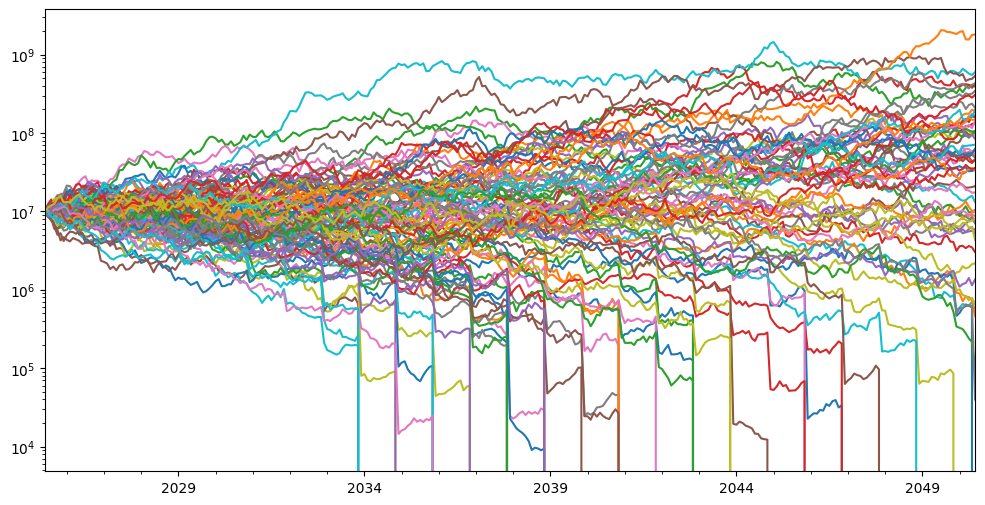

In [91]:
df.plot(legend=False)
plt.yscale('log')  # linear or log

In [260]:
sp = pf.dcf.monte_carlo_survival_period()
sp.describe([.05, .20, .30, .50, .70, .90])

count   1,000.00000
mean       19.73940
std        13.34549
min         9.50000
5%         10.50000
20%        12.50000
30%        13.50000
50%        16.50000
70%        19.50000
90%        27.60000
max       100.10000
dtype: float64

In [227]:
sp = pf.dcf.monte_carlo_survival_period()
sp.describe([.05, .20, .30, .50, .70, .90])

count   1,000.00000
mean       18.65000
std         8.45438
min         9.50000
5%         10.50000
20%        12.50000
30%        13.50000
50%        15.50000
70%        19.50000
90%        29.50000
max        50.00000
dtype: float64

<Axes: ylabel='Frequency'>

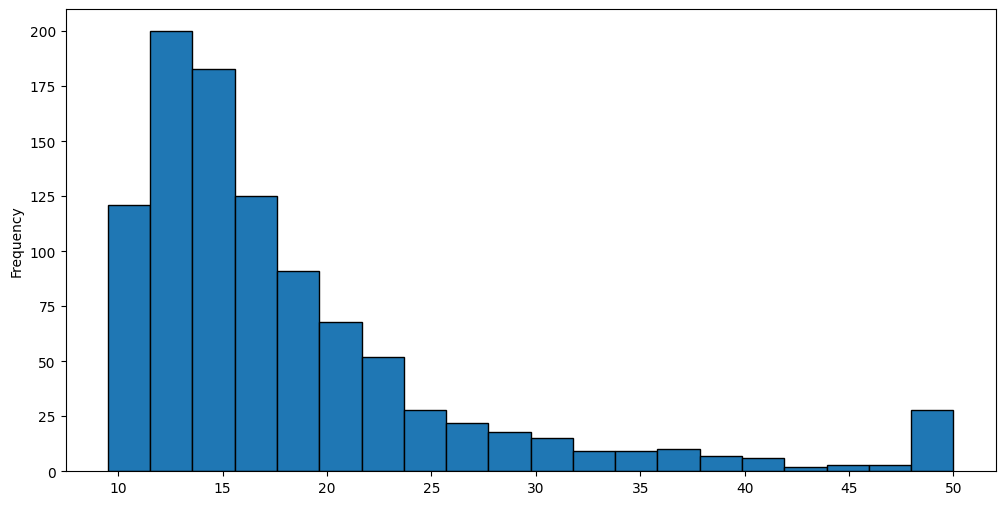

In [ ]:
sp.plot(kind="hist", bins=40, edgecolor='black')

In [229]:
cf = pf.dcf.monte_carlo_cash_flow(discounting="pv", remove_if_wealth_index_negative=True)

<Axes: >

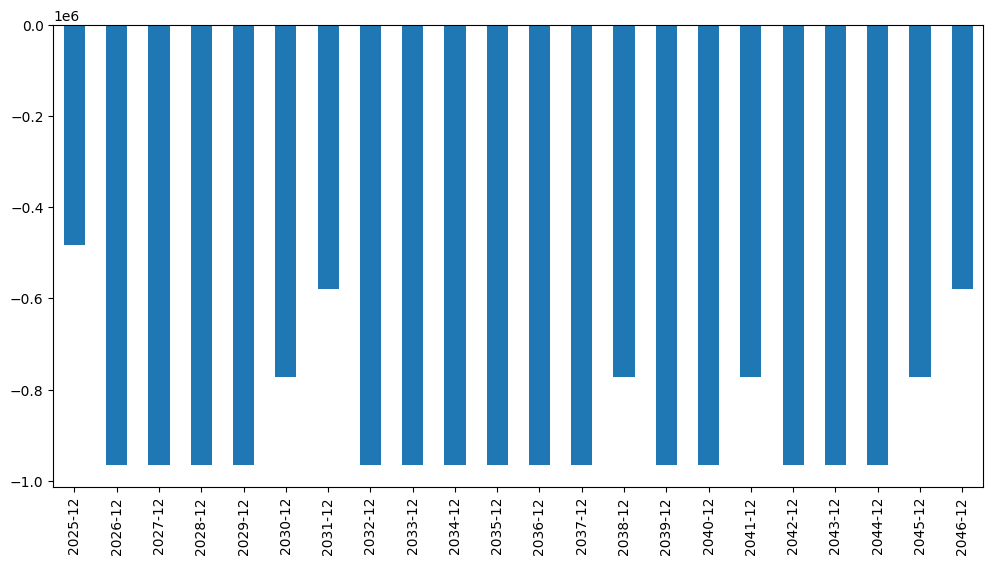

In [234]:
df = cf[4]
df[df != 0].plot(kind="bar")

In [96]:
cf_year = cf.resample("Y").last()

In [99]:
cf_year.mean().describe()

count        100.00000
mean    -593,999.20859
std      198,359.30496
min     -937,762.08594
25%     -748,232.57860
50%     -632,759.09693
75%     -422,996.84607
max     -182,556.53357
dtype: float64

In [100]:
last = cf.iloc[-1]
last[last != 0]

1    -604,324.39399
2    -302,162.19699
3    -483,459.51519
4    -120,864.87880
5    -302,162.19699
6    -604,324.39399
7    -120,864.87880
9    -604,324.39399
12   -302,162.19699
14   -302,162.19699
15   -604,324.39399
19   -302,162.19699
22   -604,324.39399
23   -604,324.39399
24   -120,864.87880
27   -302,162.19699
28   -483,459.51519
29   -604,324.39399
31   -302,162.19699
34   -604,324.39399
35   -604,324.39399
37   -483,459.51519
41   -120,864.87880
43   -302,162.19699
44   -120,864.87880
45   -302,162.19699
46   -302,162.19699
47   -483,459.51519
51   -120,864.87880
52   -302,162.19699
53   -302,162.19699
54   -302,162.19699
55   -483,459.51519
56   -604,324.39399
58   -483,459.51519
60   -604,324.39399
63   -483,459.51519
68   -120,864.87880
71   -120,864.87880
76   -483,459.51519
77   -120,864.87880
78   -302,162.19699
79   -604,324.39399
80   -483,459.51519
81   -302,162.19699
83   -483,459.51519
84   -483,459.51519
86   -302,162.19699
87   -120,864.87880
89   -483,459.51519


<Axes: ylabel='Frequency'>

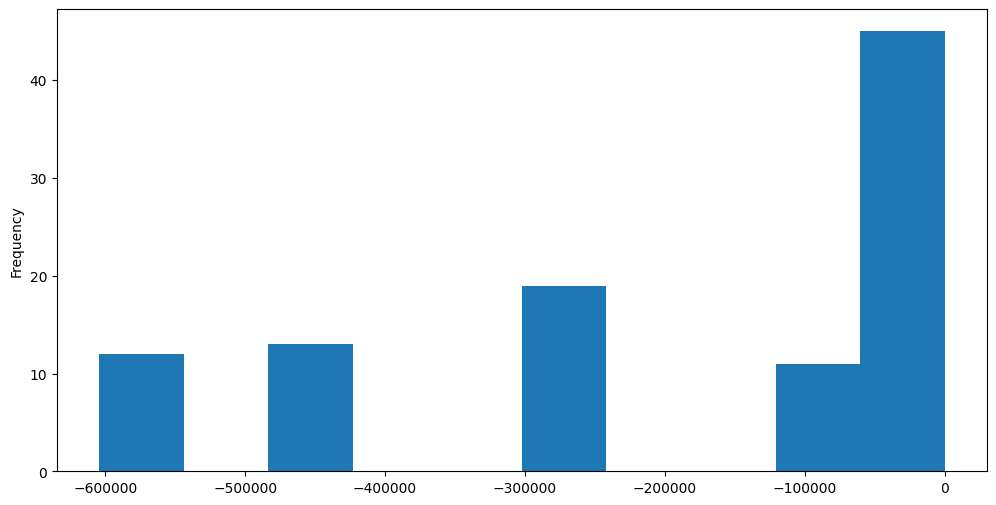

In [101]:
last.plot(kind="hist")

<Axes: ylabel='Frequency'>

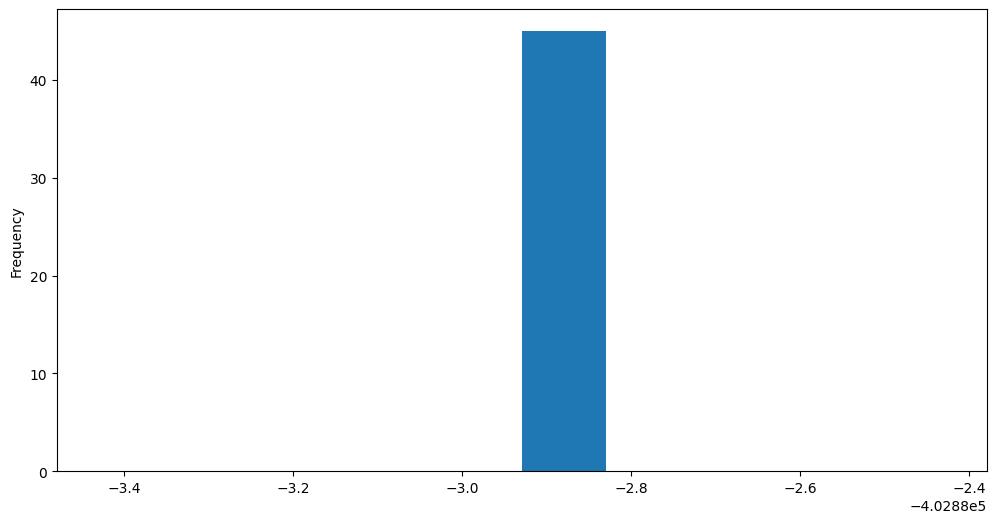

In [40]:
last[last !=0].plot(kind="hist")

<Axes: ylabel='Frequency'>

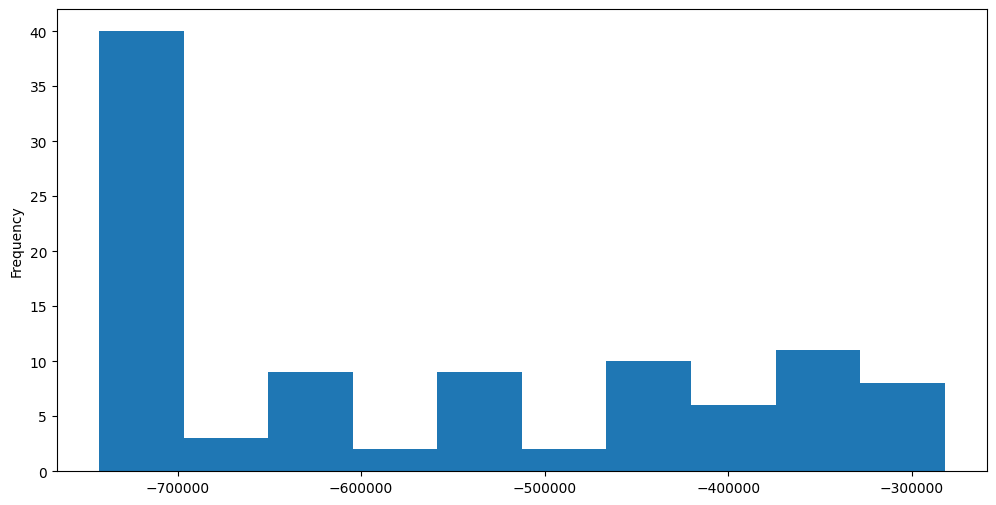

In [116]:
cf_year.mean().plot(kind="hist")

### find_the_largest_withdrawals_size

In [76]:
# assets = ["RGBITR.INDX", "RUCBTRNS.INDX", "MCFTR.INDX", "GC.COMM"]
# weights = [0.16, 0.40, 0.25, 0.19]
# pf = ok.Portfolio(assets, weights=weights, ccy="RUB", rebalancing_strategy=ok.Rebalance(period="year"), inflation=False)
# pf.dcf.discount_rate = 0.09
# print(pf)

2025-08-12 07:20:11,178 - WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPConnectionPool(host='api.okama.io', port=5000): Read timed out. (read timeout=10)")': /api/ts/ror/RUB.FX?first_date=1913-01-01&last_date=2100-01-01&period=M


symbol                                                       portfolio_2377.PF
assets                       [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                                [0.16, 0.4, 0.25, 0.19]
rebalancing_period                                                        year
rebalancing_abs_deviation                                                 None
rebalancing_rel_deviation                                                 None
currency                                                                   RUB
inflation                                                                 None
first_date                                                             2003-01
last_date                                                              2025-08
period_length                                               22 years, 8 months
dtype: object


In [10]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 2_000_000 * 90
ind.amount = -4000 * 90
ind.frequency = "month"
ind.indexation = 0.09

pf.dcf.cashflow_parameters = ind
print(ind)

Portfolio symbol                portfolio_6436.PF
Cash flow initial investment            180000000
Cash flow frequency                         month
Cash flow strategy                   fixed_amount
Cash flow amount                          -360000
Cash flow indexation                      0.09000
dtype: object


In [11]:
ind.amount * 12 / ind.initial_investment * 100

-2.4

In [12]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [13]:
pf.dcf.monte_carlo_survival_period().describe()

count   100.00000
mean     48.90300
std       3.62024
min      29.40000
25%      50.00000
50%      50.00000
75%      50.00000
max      50.00000
dtype: float64

In [8]:
mc_wealth_pv = pf.dcf.monte_carlo_wealth_pv

In [9]:
mc50years_wealth_pv = mc_wealth_pv.iloc[-1, :]
mc50years_wealth_pv.describe([0.05, 0.20, 0.30, 0.50])

count              90.00000
mean      400,707,166.39629
std       331,212,582.94797
min         8,107,953.18626
5%         39,702,834.57472
20%       143,359,085.40553
30%       200,303,716.07043
50%       308,283,047.77550
max     1,797,835,507.07551
Name: 2075-02, dtype: float64

In [14]:
pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",
    percentile=20,
    tolerance_rel=0.10,
)

wealth_at_quantile=0.00, main_parameter=-15000000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-7500000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-3750000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-1875000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=158558931.03, main_parameter=-937500.000
error_rel=0.119, gradient=-0.881
decreasing withdrawal
wealth_at_quantile=74328629.23, main_parameter=-468750.000
error_rel=0.587, gradient=0.468
decreasing withdrawal
wealth_at_quantile=203040683.89, main_parameter=-234375.000
error_rel=0.128, gradient=-0.459
increasing withdrawal
wealth_at_quantile=104638589.01, main_parameter=-351562.500
error_rel=0.419, gradient=0.291
decreasing withdrawal
wealth_at_quantile=183759035.91, main_parameter=-292968.750
error_rel=0.021, gradient=-0.398
solution found: -2929

success                    True
withdrawal_abs   -292,968.75000
withdrawal_rel          0.01953
error_rel               0.02088
attempts                      9
dtype: object

## Mean return

In [7]:
pf.mean_return_monthly

np.float64(0.011438815808118081)

In [8]:
pf.mean_return_annual

np.float64(0.13726578969741698)

In [9]:
pf.mean_return_monthly * 12 == pf.mean_return_annual

np.True_

In [12]:
pf.annual_return_ts(return_type="cagr").tail()

date
2021    0.07182
2022   -0.13409
2023    0.31363
2024    0.09941
2025    0.08415
Freq: Y-DEC, Name: portfolio_1908.PF, dtype: float64

In [13]:
pf.annual_return_ts(return_type="arithmetic_mean").tail()

date
2021    0.07123
2022   -0.12025
2023    0.27964
2024    0.09986
2025    0.08217
Freq: Y-DEC, Name: portfolio_1908.PF, dtype: float64